In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, x_l, x_r, N_bc):

    x_train = np.geomspace(x_l+0.001, x_r, N_x)
    x_bc1 = np.ones(N_bc)*x_l
    x_bc2 = np.ones(N_bc)*x_r
    x_train = np.concatenate((x_train,x_bc1,x_bc2),0)
    x_train = np_to_torch(x_train)
    N_xl = torch.sum( torch.where(x_train == x_l,1,0) ).detach().numpy().item()
    N_xr = torch.sum( torch.where(x_train == x_r,1,0) ).detach().numpy().item()
    
    return x_train, N_xl, N_xr

def initial_temp(N_x, N_bc, T_l, T_r):

    T_prev_1 = np.zeros(N_x)
    T_prev_1[0] = T_l
    T_prev_2 = np.ones(N_bc)*T_l
    T_prev_3 = np.ones(N_bc)*T_r
    T_prev = np.concatenate((T_prev_1, T_prev_2, T_prev_3),0)
    T_prev = np_to_torch(T_prev)
    
    return T_prev

def x_test_data(N_x_test, x_l, x_r):

    x_test = np.linspace(x_l, x_r, N_x_test)
    x_test_np = x_test.reshape(N_x_test,1)
    x_test_torch = np_to_torch(x_test)
    
    return x_test_np, x_test_torch
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(layer_size) - 1):
            modules.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            modules.append(nn.Tanh())

        self.fc = nn.Sequential(*modules)
        self.fc.apply(xavier_init)
        
    def forward(self, x_train):
        op = self.fc( x_train )
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]

        return op, op_x2
    
def get_loss(x_train, k1, N_tot, T_l, T_r, N_xl, N_xr, x_l, x_r, T_prev, del_t):
    
    mse = nn.MSELoss(reduction='sum')
    w1 = 1
    w2 = 1
    w3 = 1
    T, d2Tdx2 = model(x_train)
    eq1 = w1*torch.sum( torch.square(T - T_prev - del_t*k1*d2Tdx2 ) )/N_tot
    bc1 = w2*torch.sum( torch.square( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)) ) )/(N_xl)
    bc2 = w3*torch.sum( torch.square( torch.mul(torch.where(x_train == x_r,1,0),(T - T_r)) ) )/(N_xr)
    loss = eq1 + bc1 + bc2
    
    return loss, eq1, bc1, bc2

def print_loss(epoch, loss, eq1, bc1, bc2):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())

def L2_err(N_x_test, x_test, y_an, model):
    
    y_pred,_  = model(x_test)
    y_pred = y_pred.detach().numpy()

    L2_err =  np.sum((y_an - y_pred)**2)/(N_x_test)
    return L2_err

def analytical(x_test, t_test, T_l):

    i = 1
    y_an = 0
    for i in range(1, 60, 1): 
        y_an += -2*T_l*(-1)**(i+1)/(i*np.pi)*np.sin(i*np.pi*(1 - x_test))*np.exp(-(i*np.pi)**2*k1*t_test)   
    y_an += T_l*(1 - x_test)
    
    return y_an
    
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test):
    
    loss_store = []
    T_store_pred = []
    T_store_an = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
    N_tot = N_x + 2*N_bc
    print("N_tot = ", N_tot)
    x_train, N_xl, N_xr = x_train_data(N_x, x_l, x_r, N_bc)
    x_test_np, x_test_torch = x_test_data(N_x_test, x_l, x_r)
    t_test = 0
    
    for i in range(N_t):
        
        t_test = t_test + del_t
        print("t = ", t_test)
        print(" ")
        y_an = analytical(x_test_np, t_test, T_l)
        
        if(i==0):
            T_prev = initial_temp(N_x, N_bc, T_l, T_r)
        else:
            T_prev,_ = model(x_train)  
            T_prev = T_prev.clone().detach().requires_grad_(False)
        
        for epoch in range(epochs):
            
            #Backpropogation and optimisation
            loss, eq1, bc1, bc2 = get_loss(x_train, k1, N_tot, T_l, T_r, N_xl, N_xr, x_l, x_r, T_prev, del_t)
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()  
            loss_store.append(loss.detach().numpy())

            L2_norm_err = L2_err(N_x_test, x_test_torch, y_an, model)
            
            if epoch%1000==0:
                print_loss(epoch, loss, eq1, bc1, bc2)
                print("L2_err= ", L2_norm_err )
                print("")
            
            if L2_norm_err<accuracy_cap :
                print("loss limit attained, epoch = ", epoch," L2_err= ", L2_norm_err)
                print("")
                break
            
        # Store the results after each time step
        T_st,_ = model(x_test_torch)   
        T_st = T_st.detach().numpy()
        T_store_pred.append(T_st)
        T_an = analytical(x_test_np, t_test, T_l)
        T_store_an.append(T_an)
        
        print("broke inner loop")
        print("")

    return loss_store, T_store_pred, T_store_an, x_test_np

In [3]:
N_x = 51
N_bc = 35
N_t = 101
del_t = 0.005
x_l = 0
x_r = 1
T_r = 0
T_l = 1
t_i = 0
accuracy_cap = 0.0001
N_x_test = 101

# Neural network params
layer_size = [1, 25, 25, 25, 1]

# material params
k1 = 0.05

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 7e-5
epochs = 20000
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

# Training model
start = time.time()
loss_store, T_store_pred, T_store_an, x_test_np = train_model(model, optimiser1, epochs, T_r, T_l, k1, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test)
end = time.time()
time_elapsed = end - start
print("time elapsed = ", time_elapsed)

ANN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
    (6): Linear(in_features=25, out_features=1, bias=True)
    (7): Tanh()
  )
)
Total trainable parameters in the model: 1376
N_tot =  121
t =  0.005
 
epoch =  0
loss =  1.3151473
eq1_loss =  0.30192807
bc1_loss =  0.99950254
bc2_loss =  0.0137166465
L2_err=  0.021165524675879555

epoch =  1000
loss =  0.2673001
eq1_loss =  0.21504194
bc1_loss =  0.052060287
bc2_loss =  0.00019787782
L2_err=  0.2103212548386834

epoch =  2000
loss =  0.26301298
eq1_loss =  0.21398477
bc1_loss =  0.048825648
bc2_loss =  0.00020255886
L2_err=  0.19319733286243526

epoch =  3000
loss =  0.2459944
eq1_loss =  0.1980615
bc1_loss =  0.04779861
bc2_loss =  0.00013430932
L2_err=  0.12096354520681049

epoch =  4000
loss =  0.21405278
eq1_loss =  0.1722159
bc1_lo

loss limit attained, epoch =  631  L2_err=  9.999267686312475e-05

broke inner loop

t =  0.05499999999999999
 
epoch =  0
loss =  0.0002004419
eq1_loss =  8.065289e-05
bc1_loss =  0.00011975177
bc2_loss =  3.7228492e-08
L2_err=  0.00013135262644533265

loss limit attained, epoch =  727  L2_err=  9.998733916560198e-05

broke inner loop

t =  0.05999999999999999
 
epoch =  0
loss =  0.00017059018
eq1_loss =  6.445862e-05
bc1_loss =  0.00010612525
bc2_loss =  6.312778e-09
L2_err=  0.00011577330937637894

loss limit attained, epoch =  767  L2_err=  9.988052862417339e-05

broke inner loop

t =  0.06499999999999999
 
epoch =  0
loss =  0.00014871193
eq1_loss =  5.375139e-05
bc1_loss =  9.493602e-05
bc2_loss =  2.4515664e-08
L2_err=  0.00010416545386592095

loss limit attained, epoch =  755  L2_err=  9.993859846108007e-05

broke inner loop

t =  0.06999999999999999
 
epoch =  0
loss =  0.00013563373
eq1_loss =  4.957139e-05
bc1_loss =  8.589004e-05
bc2_loss =  1.7230246e-07
L2_err=  9.693967

loss limit attained, epoch =  124  L2_err=  9.999624687147813e-05

broke inner loop

t =  0.2050000000000001
 
epoch =  0
loss =  3.067824e-05
eq1_loss =  7.404364e-06
bc1_loss =  2.3246663e-05
bc2_loss =  2.7212618e-08
L2_err=  0.0001063021291271737

loss limit attained, epoch =  169  L2_err=  9.995217726485866e-05

broke inner loop

t =  0.2100000000000001
 
epoch =  0
loss =  2.9647601e-05
eq1_loss =  7.0170454e-06
bc1_loss =  2.2611917e-05
bc2_loss =  1.8638922e-08
L2_err=  0.00010559343295291948

loss limit attained, epoch =  158  L2_err=  9.993722580914618e-05

broke inner loop

t =  0.2150000000000001
 
epoch =  0
loss =  2.8935012e-05
eq1_loss =  6.919139e-06
bc1_loss =  2.19854e-05
bc2_loss =  3.0473675e-08
L2_err=  0.00010508150842345218

loss limit attained, epoch =  191  L2_err=  9.988133022518608e-05

broke inner loop

t =  0.2200000000000001
 
epoch =  0
loss =  2.8295763e-05
eq1_loss =  6.8599234e-06
bc1_loss =  2.139028e-05
bc2_loss =  4.5558437e-08
L2_err=  0.000104569

loss limit attained, epoch =  13  L2_err=  9.990244925108961e-05

broke inner loop

t =  0.3700000000000002
 
epoch =  0
loss =  1.6073498e-05
eq1_loss =  3.5806556e-06
bc1_loss =  1.2190718e-05
bc2_loss =  3.0212507e-07
L2_err=  0.00010979266190843917

loss limit attained, epoch =  334  L2_err=  9.968991612180525e-05

broke inner loop

t =  0.3750000000000002
 
epoch =  0
loss =  1.6737562e-05
eq1_loss =  4.6843375e-06
bc1_loss =  1.1834575e-05
bc2_loss =  2.1864983e-07
L2_err=  0.0001098937399607417

loss limit attained, epoch =  12  L2_err=  9.849900285112864e-05

broke inner loop

t =  0.3800000000000002
 
epoch =  0
loss =  1.6546237e-05
eq1_loss =  4.216377e-06
bc1_loss =  1.1702483e-05
bc2_loss =  6.273765e-07
L2_err=  0.00010902990267238228

loss limit attained, epoch =  9  L2_err=  9.992570894235835e-05

broke inner loop

t =  0.38500000000000023
 
epoch =  0
loss =  1.5518362e-05
eq1_loss =  3.5806654e-06
bc1_loss =  1.1589796e-05
bc2_loss =  3.479025e-07
L2_err=  0.000109866

# Results Plotter

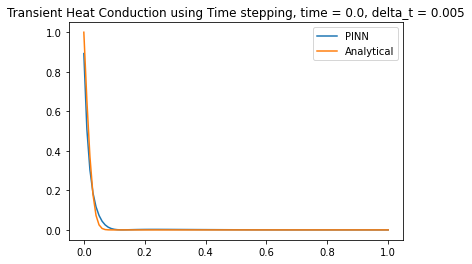

In [7]:
j = 0
plt.plot(x_test_np, T_store_pred[j])
plt.plot(x_test_np, T_store_an[j])
Title = "Transient Heat Conduction using Time stepping, " + "time = " + str(j*del_t) + ", delta_t = " + str(del_t)
plt.title(Title)
plt.legend(["PINN", "Analytical"])
plt.show()